# Big Data Modeling and Management Assigment - Homework 1

# Submission

GROUP NUMBER: **16** - please add your group number into the file name

GROUP MEMBERS:

|STUDENT NAME|STUDENT NUMBER|
|---|---|
|Benedikt Ruggaber|20240500|
|Joshua Wehr|20240501|
|Daan van Holten|20240681|

## 🍺 The Beer project  🍺 

As it was shown in classes, graph databases are a natural way of navegating related information. For this first project we will be taking a graph database to analyse beer and breweries!   

The project datasets are based on [kaggle](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews), released by Evan Hallmark. 

### Problem description

Imagine you are working in the Data Management department of Analytics company.
Explore the database via python neo4j connector and/or the graphical tool in the NEO4J webpage. Answer the questions while adjusting the database to meet the needs of your colleagues.
Please record and keep track of your database changes, and submit the file with all cells run and with the output shown.

### Questions

1. Explore the database: get familiar with current schema, elements and other important database parameters. [1 point]
2. Adjust the database and mention reasoning behind: e.g. clean errors, remove redundancies, adjust schema as necessary. Visualize the final version of database schema. [4 points]
3. Analytics department requires the following information for the biweekly reporting: [5 points]
    1. How many reviews has the beer with the most reviews?
    2. Which three users wrote the most reviews about beers?
    3. Find all beers that are described with following words: 'fruit', 'complex', 'nutty', 'dark'.
    4. Which top three breweries produce the largest variety of beer styles?
    5. Which country produces the most beer styles?
4. Market Analysis department in your company accesses and updates the trends data on the daily basis. Given that, consider how you need to optimize the database and its performance so that the following queries are efficient. Measure performance to communicate your improvements using PROFILE before final query. Answer the following: [4 points]
    1. Using ABV score, find five strongest beers, display their ABV score and the corresponding brewery? Keep in mind that the strongest known beer is Snake Venom, and deal with the error entries in the database.
    2. Using the answer from question 2, find the top 5 distict beer styles with the highest average score of smell + feel that were reviewed by the third most productive user. Keep in mind that cleaning the database earlier should ensure correct results.
5. Answer **two out of four** of the following questions using Graph Algorithms (gds): [NB: make sure to clear the graph before using it again] For the quarterly report, Analytics department the follownig information. [6 points]
    1. Which two countries are most similiar when it comes to their top five most produced Beer styles?
    2. Which beer is the most popular when considering the number of users who reviewed it? 
    3. Users are connected together by their reviews of beers, taking into consideration the "smell" score they assign as a weight, how many communities are formed from these relationships? How many users are in the three largest communities? 
    4. Which user is the most influential when it comes to reviews of distinct beers by style?
 
### Groups  

Groups should have 4 people maximum. Please mark which group you are here: https://shorturl.at/zE0QP 

### Submission      

The code used to produce the results and to-the-point explations should be uploaded to moodle. They should have a clear reference to the group, either on the file name or on the document itself. Preferably one Jupyter notebook per group.

Delivery date: Until the **midnight of March 18, 2025**

### Evaluation   

This will be 20% of the final grade.   
Each solution will be evaluated on 2 components: correctness of results and efficiency of the query (based on database schema).  
All code will go through plagiarism automated checks. Groups with the same code will undergo investigation.

## Loading the Database

#### Be sure that you **don't have** the neo4j docker container from the classes running (you can Stop it in the desktop app or with the command "`docker stop Neo4JLab`")


The default container does not have any data whatsoever, we will have to load a database into our docker image:
- Download and unzip the `Neo4JHWData` file provided in Moodle.
- Copy the path of the `Neo4JHWData` folder of the unziped file, e.g. `C:/PATH/Neo4JHWData/data`.
- Download and unzip the `Neo4JPlugins` file provided in Moodle.
- Copy the path of the `Neo4JPlugins` folder of the unziped file, e.g. `C:/PATH/Neo4Jplugins`.
- Change the code below accordingly. As you might have noticed, you do not have a user called `nunoa`, please use the appropriate path that you got from the previous step. Be sure that you have a neo4j docker container running: \

`docker run --name Neo4JHW2025 -p 7474:7474 -p 7687:7687 -d -v "c:\PATH\Neo4JPlugins":/plugins -v "c:\PATH\Neo4JHWData\data":/data --env NEO4J_AUTH=neo4j/test --env NEO4J_dbms_connector_https_advertised__address="localhost:7473" --env NEO4J_dbms_connector_http_advertised__address="localhost:7474" --env NEO4J_dbms_connector_bolt_advertised__address="localhost:7687" --env NEO4J_dbms_security_procedures_unrestricted=gds.* --env NEO4J_dbms_security_procedures_allowlist="gds.*" neo4j:4.4.5`

- Since Neo4j is trying to recognize a new database folder, this might take a bit (let's say 3 minutes), so don't worry.

If the neo4j browser fails to load gds plugins, run the following in the Command Prompt before creating the container again:
`// Remove stopped containers //
docker container prune -f
// Remove unused images //
docker image prune -a -f
// Remove unused volumes //
docker volume prune -f
// Remove unused networks //
docker network prune -f
// Remove all unused resources in one command //
docker system prune -a -f`

In [399]:
from neo4j import GraphDatabase
from pprint import pprint
import pandas as pd
from IPython.display import Image

In [347]:
NEO4J_URI="neo4j://localhost:7687"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="test"

In [348]:
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD), )

Read and write functions for future use

In [349]:
def execute_read(driver, query):    
    with driver.session(database="neo4j") as session:
        result = session.execute_read(lambda tx, query: list(tx.run(query)), query)
    return result

In [350]:
def execute_write(driver, query):
    with driver.session(database="neo4j") as session:
        result = session.execute_write(lambda tx, query: list(tx.run(query)), query)
    return result

# 1. Overview of the data


The "IN" self reference comes from duplicates in cities as shown in the duplicate check below

In [351]:
query = """
        CALL db.schema.visualization();
    """

result = execute_read(driver, query)

pprint(result)

[<Record nodes=[<Node element_id='-26' labels=frozenset({'REVIEWS'}) properties={'name': 'REVIEWS', 'indexes': ['id'], 'constraints': []}>, <Node element_id='-25' labels=frozenset({'BEERS'}) properties={'name': 'BEERS', 'indexes': ['id'], 'constraints': []}>, <Node element_id='-22' labels=frozenset({'COUNTRIES'}) properties={'name': 'COUNTRIES', 'indexes': ['name'], 'constraints': []}>, <Node element_id='-24' labels=frozenset({'BREWERIES'}) properties={'name': 'BREWERIES', 'indexes': ['id'], 'constraints': []}>, <Node element_id='-27' labels=frozenset({'STYLE'}) properties={'name': 'STYLE', 'indexes': ['name'], 'constraints': []}>, <Node element_id='-23' labels=frozenset({'CITIES'}) properties={'name': 'CITIES', 'indexes': ['name'], 'constraints': []}>, <Node element_id='-28' labels=frozenset({'USER'}) properties={'name': 'USER', 'indexes': ['name'], 'constraints': []}>] relationships=[<Relationship element_id='-25' nodes=(<Node element_id='-25' labels=frozenset({'BEERS'}) properties={

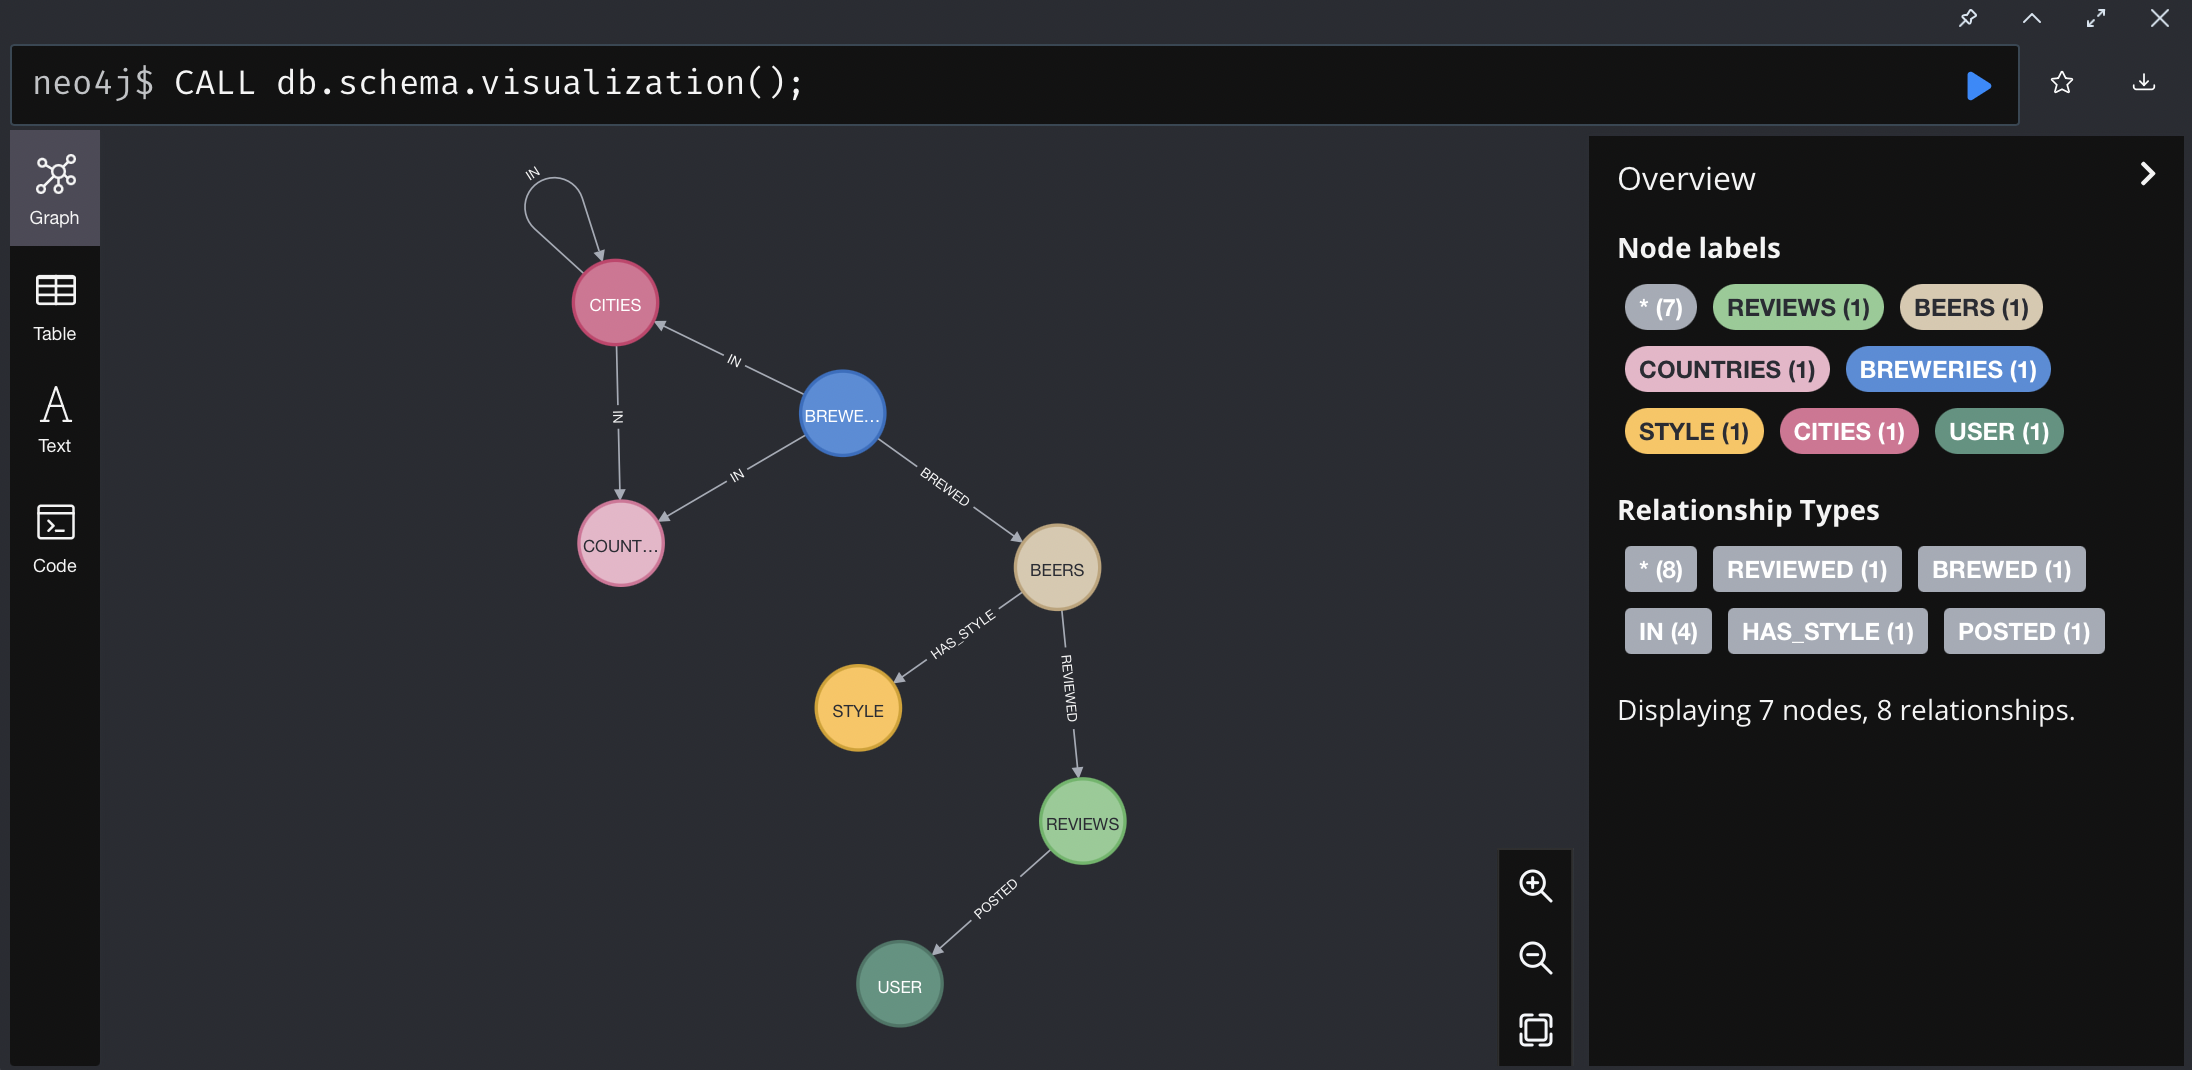

In [402]:
display(Image(filename="BDMM_Overview_before.png"))

list all unique labels

In [352]:
query = """
MATCH (n) 
RETURN DISTINCT labels(n) AS NodeTypes;
"""

result = execute_read(driver, query)
pprint(result)  


[<Record NodeTypes=['COUNTRIES']>,
 <Record NodeTypes=['CITIES']>,
 <Record NodeTypes=['BREWERIES']>,
 <Record NodeTypes=['BEERS']>,
 <Record NodeTypes=['REVIEWS']>,
 <Record NodeTypes=['STYLE']>,
 <Record NodeTypes=['USER']>]


list all relationsships

In [353]:
query = """
MATCH ()-[r]-() 
RETURN DISTINCT type(r) AS RelationshipTypes;
"""

result = execute_read(driver, query)
pprint(result)  # Print relationship types


[<Record RelationshipTypes='IN'>,
 <Record RelationshipTypes='BREWED'>,
 <Record RelationshipTypes='HAS_STYLE'>,
 <Record RelationshipTypes='REVIEWED'>,
 <Record RelationshipTypes='POSTED'>]


In [354]:
query = """
CALL db.stats.retrieve('GRAPH COUNTS');
"""

result = execute_read(driver, query)
pprint(result)  # Print database stats

[<Record section='GRAPH COUNTS' data={'relationships': [{'count': 5856205}, {'relationshipType': 'REVIEWED', 'count': 2537991}, {'relationshipType': 'REVIEWED', 'startLabel': 'BEERS', 'count': 2537991}, {'relationshipType': 'REVIEWED', 'count': 2537991, 'endLabel': 'REVIEWS'}, {'relationshipType': 'BREWED', 'count': 358873}, {'relationshipType': 'BREWED', 'startLabel': 'BREWERIES', 'count': 358873}, {'relationshipType': 'BREWED', 'count': 358873, 'endLabel': 'BEERS'}, {'relationshipType': 'IN', 'count': 62424}, {'relationshipType': 'IN', 'count': 12077, 'endLabel': 'COUNTRIES'}, {'relationshipType': 'IN', 'startLabel': 'CITIES', 'count': 12077}, {'relationshipType': 'IN', 'count': 50347, 'endLabel': 'CITIES'}, {'relationshipType': 'IN', 'startLabel': 'BREWERIES', 'count': 50347}, {'relationshipType': 'HAS_STYLE', 'count': 358873}, {'relationshipType': 'HAS_STYLE', 'startLabel': 'BEERS', 'count': 358873}, {'relationshipType': 'HAS_STYLE', 'count': 358873, 'endLabel': 'STYLE'}, {'relatio

count each node

In [355]:
query = """
MATCH (n) 
RETURN labels(n)[0] AS NodeType, count(n) AS Count
ORDER BY Count DESC;
"""

result = execute_read(driver, query)
pprint(result)  # Print node type counts


[<Record NodeType='REVIEWS' Count=2538044>,
 <Record NodeType='BEERS' Count=358873>,
 <Record NodeType='USER' Count=106645>,
 <Record NodeType='BREWERIES' Count=50347>,
 <Record NodeType='CITIES' Count=11665>,
 <Record NodeType='COUNTRIES' Count=200>,
 <Record NodeType='STYLE' Count=113>]


Nodes without labels?

In [356]:
query = """
MATCH (n)
WHERE size(labels(n)) = 0
RETURN count(n) AS nodes_without_labels;
"""

result = execute_read(driver, query)
pprint(result)  # Should return the count of nodes without labels

[<Record nodes_without_labels=0>]


count relationships

In [357]:
query = """
MATCH ()-[r]->() 
RETURN type(r) AS RelationshipType, count(r) AS Count
ORDER BY Count DESC;
"""

result = execute_read(driver, query)
pprint(result)  # Print relationship counts


[<Record RelationshipType='POSTED' Count=2538044>,
 <Record RelationshipType='REVIEWED' Count=2537991>,
 <Record RelationshipType='BREWED' Count=358873>,
 <Record RelationshipType='HAS_STYLE' Count=358873>,
 <Record RelationshipType='IN' Count=62424>]


# DATA CLEANING


Check for duplicates:

In [358]:
# Check for duplicate nodes based on a unique property, e.g., 'id'
query = """
MATCH (n)
WITH n.id AS nodeId, COUNT(*) AS count
WHERE count > 1
RETURN nodeId, count;
"""
# Convert the result to a pandas DataFrame
df_duplicates = pd.DataFrame([dict(record) for record in result])

# Display the DataFrame
df_duplicates
result = execute_read(driver, query)
pprint(result)  # Print duplicate nodes based on 'id'

[<Record nodeId=None count=118623>,
 <Record nodeId='19730' count=2>,
 <Record nodeId='32541' count=2>,
 <Record nodeId='44736' count=2>,
 <Record nodeId='23372' count=2>,
 <Record nodeId='35328' count=2>,
 <Record nodeId='31561' count=2>,
 <Record nodeId='35975' count=2>,
 <Record nodeId='5618' count=3>,
 <Record nodeId='30916' count=3>,
 <Record nodeId='41278' count=3>,
 <Record nodeId='31711' count=3>,
 <Record nodeId='12324' count=2>,
 <Record nodeId='49850' count=2>,
 <Record nodeId='16995' count=3>,
 <Record nodeId='45715' count=2>,
 <Record nodeId='45617' count=2>,
 <Record nodeId='28685' count=2>,
 <Record nodeId='47633' count=3>,
 <Record nodeId='31986' count=2>,
 <Record nodeId='47464' count=2>,
 <Record nodeId='8590' count=2>,
 <Record nodeId='8070' count=2>,
 <Record nodeId='26695' count=2>,
 <Record nodeId='53919' count=2>,
 <Record nodeId='17834' count=2>,
 <Record nodeId='17675' count=2>,
 <Record nodeId='28200' count=2>,
 <Record nodeId='48475' count=2>,
 <Record nodeId

Idea: Delete all null ID duplicates 

Decision: We ended up not deleting the nodes, because the machine ran out of memory (there were 147778 null ID Nodes)

We find dublicates in cities:

find duplicates in brewery

--------------------------

# No Relationship nodes treatment

In [359]:
query = """
MATCH (n)
RETURN COUNT(n) AS total_nodes;
"""

result = execute_read(driver, query)
pprint(result)  # Should return the total number of nodes

[<Record total_nodes=3065906>]


Find Nodes without relationships (can we consided them useless)

In [360]:
query = """
MATCH (n)
WHERE NOT (n)--()
RETURN COUNT(n) AS nodes_without_relationships;
"""

result = execute_read(driver, query)
pprint(result)  # Should return the count of nodes without relationships

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: } {title: This feature is deprecated and will be removed in future versions.} {description: Coercion of list to boolean is deprecated. Please consider using `NOT isEmpty(...)` instead.} {position: line: 3, column: 11, offset: 21} for query: '\nMATCH (n)\nWHERE NOT (n)--()\nRETURN COUNT(n) AS nodes_without_relationships;\n'


[<Record nodes_without_relationships=0>]


Delete Nodes without relationships

In [361]:
query = """
MATCH (n)
WHERE NOT (n)--()
DETACH DELETE n;
"""

execute_write(driver, query)
print("Nodes without relationships deleted successfully.")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: } {title: This feature is deprecated and will be removed in future versions.} {description: Coercion of list to boolean is deprecated. Please consider using `NOT isEmpty(...)` instead.} {position: line: 3, column: 11, offset: 21} for query: '\nMATCH (n)\nWHERE NOT (n)--()\nDETACH DELETE n;\n'


Nodes without relationships deleted successfully.


In [362]:
query = """
MATCH (n)
RETURN COUNT(n) AS total_nodes;
"""

result = execute_read(driver, query)
pprint(result)  # Should return the total number of nodes

[<Record total_nodes=3065906>]


# Finding all fields of the note type Review

In [363]:
query = """
MATCH (r:REVIEWS)
RETURN DISTINCT keys(r) AS review_fields
LIMIT 1;
"""

result = execute_read(driver, query)
pprint(result)  # This will display the fields of the REVIEWS nodes

[<Record review_fields=['text', 'smell', 'look', 'taste', 'feel', 'overall', 'beer_id', 'id', 'date', 'score']>]


Question: do we have useless Beer Reviews?

We found, that there are 19 reviews without a score and 19 reviews without text. By checking with the below query we verified that these reveiws are still valubale, because the once wihtout text have a score and vise versa.

In [364]:
query = """
MATCH (r:REVIEWS)
WHERE r.score AND r.text IS NULL
RETURN COUNT(r) as null_id_reviews
"""
result = execute_read(driver, query)
pprint(result)

[<Record null_id_reviews=0>]


---------

# 3. Queries

    1. How many reviews has the beer with the most reviews?


ToDo: don't check for r.text is null because of the finding above!

In [365]:
query = """
MATCH (b:BEERS)-[:REVIEWED]->(r:REVIEWS)
WITH b, COUNT(r) AS review_count
ORDER BY review_count DESC
LIMIT 1
RETURN b.name AS beer_name, review_count;
"""

result = execute_read(driver, query)
pprint(result)  # return the beer with the most reviews and its review count

[<Record beer_name='Breakfast Stout' review_count=4833>]



    2. Which three users wrote the most reviews about beers?


In [383]:
query = """
MATCH (r:REVIEWS)-[:POSTED]->(u:USER)
RETURN u.name AS User, COUNT(r) AS ReviewCount
ORDER BY ReviewCount DESC
LIMIT 3;
"""

result = execute_read(driver, query)
pprint(result)

[<Record User='Sammy' ReviewCount=3756>,
 <Record User='acurtis' ReviewCount=3403>,
 <Record User='kylehay2004' ReviewCount=3368>]


    3. Find all beers that are described with following words: 'fruit', 'complex', 'nutty', 'dark'.


In [385]:
# we have two verisons here: OR and AND (She wants "all words are expected to be used together")
query = """
MATCH (b:BEERS)
WHERE 
    b.notes CONTAINS 'fruit' AND 
    b.notes CONTAINS 'complex' AND 
    b.notes CONTAINS 'nutty' AND 
    b.notes CONTAINS 'dark'
RETURN DISTINCT b.name;
"""

result = execute_read(driver, query)
pprint(result)  # Should return beers with those descriptions


[<Record b.name='Legalize Hemp Ale'>,
 <Record b.name="Brother David's Belgian-style Double Ale">]


    4. Which top three breweries produce the largest variety of beer styles?


In [386]:
query = """
MATCH (br:BREWERIES)-[:BREWED]->(b:BEERS)-[:HAS_STYLE]->(s:STYLE)
WITH br.name AS brewery, COUNT(DISTINCT s.name) AS unique_styles
ORDER BY unique_styles DESC
LIMIT 3
RETURN brewery, unique_styles;
"""

result = execute_read(driver, query)
pprint(result) 


[<Record brewery='Iron Hill Brewery & Restaurant' unique_styles=94>,
 <Record brewery='Rock Bottom Restaurant & Brewery' unique_styles=93>,
 <Record brewery='Goose Island Beer Co.' unique_styles=88>]


        5. Which country produces the most beer styles?

In [387]:
query = """
MATCH (c:COUNTRIES)<-[:IN]-(city:CITIES)<-[:IN]-(br:BREWERIES)-[:BREWED]->(b:BEERS)-[:HAS_STYLE]->(s:STYLE)
WITH c.name AS country, COUNT(DISTINCT s.name) AS unique_styles
ORDER BY unique_styles DESC
LIMIT 1
RETURN country, unique_styles;
"""

result = execute_read(driver, query)
pprint(result)  


[<Record country='US' unique_styles=113>]


# 4.


Market Analysis department in your company accesses and updates the trends data on the daily basis. Given that, consider how you need to optimize the database and its performance so that the following queries are efficient. Measure performance to communicate your improvements using PROFILE before final query. Answer the following: [4 points]


    1. Using ABV score, find five strongest beers, display their ABV score and the corresponding brewery? Keep in mind that the strongest known beer is Snake Venom, and deal with the error entries in the database.

In [388]:
query = """
MATCH (br:BREWERIES)-[:BREWED]->(b:BEERS)
WITH br, b, toFloat(b.abv) AS abv_float
WHERE b.abv IS NOT NULL
WITH br, b, abv_float
WHERE abv_float > 0 AND abv_float <= 67.5
WITH br, b, abv_float, rand() AS random_value  // Adds unnecessary computation
ORDER BY random_value DESC, abv_float DESC  // Sorting twice (adds complexity)
RETURN b.name AS beer_name, abv_float AS abv_score, br.name AS brewery
ORDER BY abv_float DESC
LIMIT 5;
"""

result = execute_read(driver, query)
pprint(result)

[<Record beer_name='Snake Venom' abv_score=67.5 brewery='Brewmeister'>,
 <Record beer_name='series 3' abv_score=66.0 brewery='Redline Brewhouse'>,
 <Record beer_name='Armageddon' abv_score=65.0 brewery='Brewmeister'>,
 <Record beer_name='Start The Future' abv_score=60.0 brewery="Brouwerij 't Koelschip">,
 <Record beer_name='Schorschbräu Schorschbock 57%' abv_score=57.5 brewery='Schorschbräu'>]


But after looking at Profile of this query, we optimized the query to make it faster by reducing double filtering and multiple sort operations.

Check the two screenshots below for the query visualization

![1st Query][def]


[def]: 1stQuery.png

![2nd Query](2ndQuery.png)

In [389]:
query = """
MATCH (br:BREWERIES)-[:BREWED]->(b:BEERS)
WHERE b.abv IS NOT NULL
WITH b, br, toFloat(b.abv) as abv_float
WHERE abv_float > 0 AND abv_float <= 67.5
RETURN b.name AS beer_name, abv_float AS abv_score, br.name AS brewery
ORDER BY abv_float DESC
LIMIT 5;
"""

result = execute_read(driver, query)
pprint(result)

[<Record beer_name='Snake Venom' abv_score=67.5 brewery='Brewmeister'>,
 <Record beer_name='series 3' abv_score=66.0 brewery='Redline Brewhouse'>,
 <Record beer_name='Armageddon' abv_score=65.0 brewery='Brewmeister'>,
 <Record beer_name='Start The Future' abv_score=60.0 brewery="Brouwerij 't Koelschip">,
 <Record beer_name='Schorschbräu Schorschbock 57%' abv_score=57.5 brewery='Schorschbräu'>]


        2. Using the answer from question 2, find the top 5 distict beer styles with the highest average score of smell + feel that were reviewed by 

In [390]:
query = """
// Find all beer styles and calculate the average smell + feel score for each
MATCH (r:REVIEWS)<-[:REVIEWED]-(b:BEERS)-[:HAS_STYLE]->(s:STYLE)
WHERE r.smell IS NOT NULL 
  AND r.feel IS NOT NULL
  AND s.name IS NOT NULL
  AND s.name <> "nan"
  AND s.name <> ""

// Calculate the average smell + feel score for each style
WITH s.name AS beer_style, AVG(toFloat(r.smell) + toFloat(r.feel)) AS avg_score
WHERE avg_score IS NOT NULL

// Return the top 5 styles with highest average score
RETURN beer_style, avg_score
ORDER BY avg_score DESC
LIMIT 5;
"""

result = execute_read(driver, query)
pprint(result)

[<Record beer_style='New England IPA' avg_score=8.792995379793723>,
 <Record beer_style='American Imperial Stout' avg_score=8.49245855991279>,
 <Record beer_style='Belgian Gueuze' avg_score=8.421866737176126>,
 <Record beer_style='American Imperial Porter' avg_score=8.326940877010319>,
 <Record beer_style='Russian Imperial Stout' avg_score=8.29099522620976>]


Improved Query

In [391]:
query = """
MATCH (s:STYLE)<-[:HAS_STYLE]-(b:BEERS)-[:REVIEWED]->(r:REVIEWS)
WHERE r.smell IS NOT NULL 
    AND r.feel IS NOT NULL
    AND s.name IS NOT NULL
    AND s.name <> "nan"
    AND s.name <> ""

// Ensure numerical conversion before aggregation
WITH s.name AS beer_style, 
         AVG(toFloat(r.smell) + toFloat(r.feel)) AS avg_score
WHERE avg_score IS NOT NULL  // Ignore scores that are None

// Return the top 5 styles with the highest average score
RETURN beer_style, avg_score
ORDER BY avg_score DESC
LIMIT 5;
"""

result = execute_read(driver, query)
pprint(result)

[<Record beer_style='New England IPA' avg_score=8.792995379793723>,
 <Record beer_style='American Imperial Stout' avg_score=8.49245855991279>,
 <Record beer_style='Belgian Gueuze' avg_score=8.421866737176126>,
 <Record beer_style='American Imperial Porter' avg_score=8.326940877010319>,
 <Record beer_style='Russian Imperial Stout' avg_score=8.29099522620976>]


# 5.

5. Answer **two out of four** of the following questions using Graph Algorithms (gds): [NB: make sure to clear the graph before using it again] For the quarterly report, Analytics department the follownig information. [6 points]
    1. Which two countries are most similiar when it comes to their top five most produced Beer styles?
    2. Which beer is the most popular when considering the number of users who reviewed it? 
    3. Users are connected together by their reviews of beers, taking into consideration the "smell" score they assign as a weight, how many communities are formed from these relationships? How many users are in the three largest communities? 
    4. Which user is the most influential when it comes to reviews of distinct beers by style?

    1. Which two countries are most similiar when it comes to their top five most produced Beer styles?

In [392]:
query = """
// Step 1: Find top 5 beer styles for each country
MATCH (c:COUNTRIES)<-[:IN]-(:CITIES)<-[:IN]-(br:BREWERIES)-[:BREWED]->(b:BEERS)-[:HAS_STYLE]->(s:STYLE)
WHERE c.name IS NOT NULL AND s.name IS NOT NULL AND s.name <> "nan" AND s.name <> ""
WITH c.name AS country, s.name AS style, COUNT(b) AS beer_count
ORDER BY country, beer_count DESC
WITH country, COLLECT(style)[0..5] AS top_styles
WHERE SIZE(top_styles) = 5

// Step 2: Compare all country pairs
WITH COLLECT({country: country, styles: top_styles}) AS country_data
UNWIND country_data AS cd1
UNWIND country_data AS cd2
WITH cd1, cd2
WHERE cd1.country < cd2.country  // Now the WHERE clause is after a WITH

// Step 3: Calculate similarity (number of common styles)
WITH cd1.country AS country1, cd2.country AS country2,
     [s IN cd1.styles WHERE s IN cd2.styles] AS common_styles
WITH country1, country2, common_styles, SIZE(common_styles) AS similarity

// Step 4: Return the most similar pair
RETURN country1, country2, common_styles, similarity
ORDER BY similarity DESC
LIMIT 1;
"""

result = execute_read(driver, query)
pprint(result)

[<Record country1='AU' country2='NZ' common_styles=['American IPA', 'American Pale Ale (APA)', 'American Imperial IPA', 'Belgian Saison', 'American Imperial Stout'] similarity=5>]


    2. Which beer is the most popular when considering the number of users who reviewed it? 

In [ ]:
try:
    clear_query = """
    CALL gds.graph.drop('beer_popularity_graph')
    YIELD graphName
    """
    execute_read(driver, clear_query)
except Exception as e:
    print("No previous graph to clear or", e)

create_graph_query = """
CALL gds.graph.project.cypher(
    'beer_popularity_graph',
    
    'MATCH (n) WHERE n:BEERS OR n:USER RETURN id(n) AS id', 
    
    'MATCH (b:BEERS)-[:REVIEWED]->(r:REVIEWS)-[:POSTED]->(u:USER) 
     RETURN id(b) AS source, id(u) AS target'
)
"""
execute_read(driver, create_graph_query)

# use the degree algorithm from GDS to find the most popular beer
popular_beer_query = """
CALL gds.degree.stream('beer_popularity_graph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE node:BEERS
RETURN node.name AS beer_name, 
       node.id AS beer_id, 
       score AS number_of_unique_reviewers
ORDER BY number_of_unique_reviewers DESC
LIMIT 1
"""
result = execute_read(driver, popular_beer_query)
pprint(result)

# Drop the graph
cleanup_query = """
CALL gds.graph.drop('beer_popularity_graph')
"""
execute_read(driver, cleanup_query)

/var/folders/vw/pymryqyn3hv91xzpkt7_kblw0000gn/T/ipykernel_53135/4127478203.py:2: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database="neo4j") as session:


No previous graph to clear or {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: java.util.NoSuchElementException: Graph with name `beer_popularity_graph` does not exist on database `neo4j`. It might exist on another database.}
[<Record beer_name='Breakfast Stout' beer_id='11757' number_of_unique_reviewers=4833.0>]


[<Record graphName='beer_popularity_graph' database='neo4j' memoryUsage='' sizeInBytes=-1 nodeCount=465518 relationshipCount=2537991 configuration={'relationshipQuery': 'MATCH (b:BEERS)-[:REVIEWED]->(r:REVIEWS)-[:POSTED]->(u:USER) \n     RETURN id(b) AS source, id(u) AS target', 'jobId': '700cc4b4-5d95-4d61-929d-fe40c9abd780', 'creationTime': neo4j.time.DateTime(2025, 3, 18, 18, 40, 1, 413927000, tzinfo=<StaticTzInfo 'Etc/UTC'>), 'validateRelationships': True, 'nodeQuery': 'MATCH (n) WHERE n:BEERS OR n:USER RETURN id(n) AS id', 'sudo': True, 'readConcurrency': 4, 'parameters': []} density=1.171164915990589e-05 creationTime=neo4j.time.DateTime(2025, 3, 18, 18, 40, 1, 413927000, tzinfo=<StaticTzInfo 'Etc/UTC'>) modificationTime=neo4j.time.DateTime(2025, 3, 18, 18, 40, 9, 983208000, tzinfo=<StaticTzInfo 'Etc/UTC'>) schema={'graphProperties': {}, 'relationships': {'__ALL__': {}}, 'nodes': {'__ALL__': {}}}>]

    4. Which user is the most influential when it comes to reviews of distinct beers by style?

In [ ]:
try:
    clear_query = """
    CALL gds.graph.drop('user_style_influence_graph')
    YIELD graphName
    """
    execute_read(driver, clear_query)
except Exception as e:
    print("No previous graph to clear or", e)

# Create a projected graph connecting users to beer styles through reviews
create_graph_query = """
CALL gds.graph.project.cypher(
    'user_style_influence_graph',
    
    'MATCH (n) WHERE n:USER OR n:STYLE RETURN id(n) AS id', 
    
    'MATCH (u:USER)<-[:POSTED]-(r:REVIEWS)<-[:REVIEWED]-(b:BEERS)-[:HAS_STYLE]->(s:STYLE) 
     RETURN id(u) AS source, id(s) AS target'
)
"""
execute_read(driver, create_graph_query)

# Use degree centrality to find which user is connected to the most distinct beer styles
influential_user_query = """
CALL gds.degree.stream('user_style_influence_graph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE node:USER
RETURN node.name AS user_name, 
       id(node) AS user_id, 
       score AS distinct_beer_styles_reviewed
ORDER BY distinct_beer_styles_reviewed DESC
LIMIT 1
"""
result = execute_read(driver, influential_user_query)
pprint(result)

# Drop the graph
cleanup_query = """
CALL gds.graph.drop('user_style_influence_graph')
"""
execute_read(driver, cleanup_query)

/var/folders/vw/pymryqyn3hv91xzpkt7_kblw0000gn/T/ipykernel_53135/4127478203.py:2: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database="neo4j") as session:


No previous graph to clear or {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: java.util.NoSuchElementException: Graph with name `user_style_influence_graph` does not exist on database `neo4j`. It might exist on another database.}
[<Record user_name='Sammy' user_id=9494470 distinct_beer_styles_reviewed=3756.0>]


[<Record graphName='user_style_influence_graph' database='neo4j' memoryUsage='' sizeInBytes=-1 nodeCount=106758 relationshipCount=2537991 configuration={'relationshipQuery': 'MATCH (u:USER)<-[:POSTED]-(r:REVIEWS)<-[:REVIEWED]-(b:BEERS)-[:HAS_STYLE]->(s:STYLE) \n     RETURN id(u) AS source, id(s) AS target', 'jobId': '1375affb-fd5d-4e92-8c1a-53abc0d4f666', 'creationTime': neo4j.time.DateTime(2025, 3, 18, 18, 40, 27, 362427000, tzinfo=<StaticTzInfo 'Etc/UTC'>), 'validateRelationships': True, 'nodeQuery': 'MATCH (n) WHERE n:USER OR n:STYLE RETURN id(n) AS id', 'sudo': True, 'readConcurrency': 4, 'parameters': []} density=0.00022268619133682037 creationTime=neo4j.time.DateTime(2025, 3, 18, 18, 40, 27, 362427000, tzinfo=<StaticTzInfo 'Etc/UTC'>) modificationTime=neo4j.time.DateTime(2025, 3, 18, 18, 40, 30, 350613000, tzinfo=<StaticTzInfo 'Etc/UTC'>) schema={'graphProperties': {}, 'relationships': {'__ALL__': {}}, 'nodes': {'__ALL__': {}}}>]

-------------